In [0]:
# imports 
import os
import time
import datetime
import json
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import metrics
from itertools import product
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder

In [33]:
from google.colab import files
uploaded_3 = files.upload()

Saving structures.csv to structures (3).csv


In [29]:
from google.colab import files
uploaded_2 = files.upload()

Saving sample_submission.csv to sample_submission (3).csv


In [15]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test (1).csv
Saving train.csv to train (1).csv


In [0]:
import io
train = pd.read_csv(io.StringIO(uploaded['train.csv'].decode('utf-8')))
test = pd.read_csv(io.StringIO(uploaded['test.csv'].decode('utf-8')))


In [0]:
sub = pd.read_csv(io.StringIO(uploaded_2['sample_submission.csv'].decode('utf-8')))


In [0]:
structures = pd.read_csv(io.StringIO(uploaded_3['structures.csv'].decode('utf-8')))

In [35]:
print('Train shape: ',train.shape)
print('Test shape: ',test.shape)
print('Structures shape: ',structures.shape)

Train shape:  (4658147, 6)
Test shape:  (2505542, 5)
Structures shape:  (2358657, 6)


In [36]:
print(f'{train.shape[0]} строк в тренировочной выборке.')
print(f'{test.shape[0]} строк в тренировочной выборке.')

print(f"{train['molecule_name'].nunique()} выявленных молекул в тренировочной выборке.")
print(f"{test['molecule_name'].nunique()} выявленных молекул в тестовой выборке.")
print(f"{structures['atom'].nunique()} уникальных атомов.")
print(f"{train['type'].nunique()} уникальных видов.")

4658147 строк в тренировочной выборке.
2505542 строк в тренировочной выборке.
85003 выявленных молекул в тренировочной выборке.
45772 выявленных молекул в тестовой выборке.
5 уникальных атомов.
8 уникальных видов.


In [37]:
train.describe()

,id,atom_index_0,atom_index_1,scalar_coupling_constant
count,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06
mean,2.329073e+06,1.335689e+01,5.883966e+00,1.592165e+01
std,1.344691e+06,3.267712e+00,4.993943e+00,3.494198e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-3.621860e+01
25%,1.164536e+06,1.100000e+01,2.000000e+00,-2.549780e-01
50%,2.329073e+06,1.300000e+01,5.000000e+00,2.281130e+00
75%,3.493610e+06,1.600000e+01,8.000000e+00,7.390655e+00
max,4.658146e+06,2.800000e+01,2.800000e+01,2.048800e+02


In [38]:
structures.describe()

,atom_index,x,y,z
count,2.358657e+06,2.358657e+06,2.358657e+06,2.358657e+06
mean,8.757349e+00,9.489178e-02,-3.337381e-01,6.241504e-02
std,5.592487e+00,1.655271e+00,1.989152e+00,1.445870e+00
min,0.000000e+00,-9.234889e+00,-9.933938e+00,-9.134765e+00
25%,4.000000e+00,-8.746097e-01,-1.826156e+00,-8.424896e-01
50%,9.000000e+00,5.183615e-02,-4.035932e-01,1.093207e-02
75%,1.300000e+01,1.116101e+00,1.373660e+00,9.394357e-01
max,2.800000e+01,9.382240e+00,1.018196e+01,7.894733e+00


Text(0, 0.5, 'count')

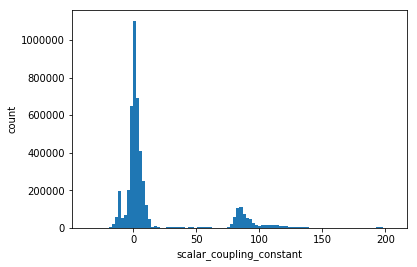

In [39]:
plt.hist(train.scalar_coupling_constant,bins=100)
plt.xlabel('scalar_coupling_constant')
plt.ylabel('count')

**Отметим что в данных есть по крайней мере два/три различных нормальных распределения. Распределение константы связи может иметь связь с распределениями одной из этих переменных.**

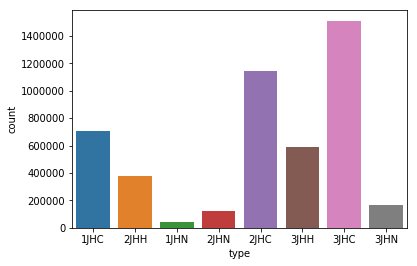

In [42]:
sns.countplot(x="type", data=train)

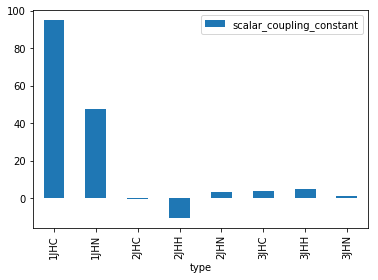

In [43]:
train[['type','scalar_coupling_constant']].groupby('type').mean().plot.bar()

**Константа связи показывает сильную связь с типом связи.Рассмотрим все распределение.**

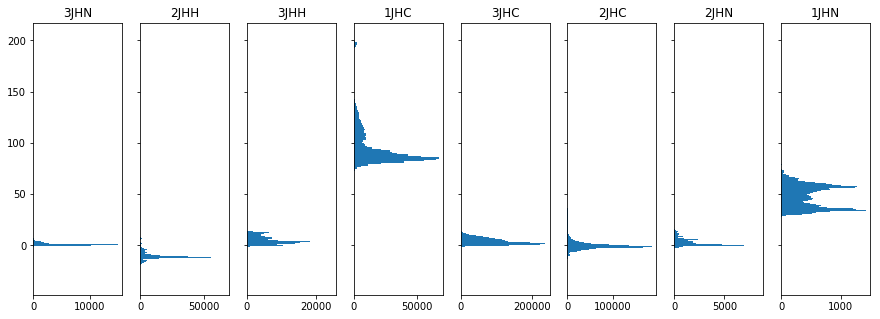

In [44]:
f, ax = plt.subplots(1, 8, sharex='col', sharey='row', figsize=(15,5))

for i,t in enumerate(set(train.type)):
    ax[i].hist(train[train.type==t].scalar_coupling_constant,orientation="horizontal", bins=100) 
    ax[i].set_title(t)

**В зависимости от типа связи, константа связи имеет определенную форму распределения.**

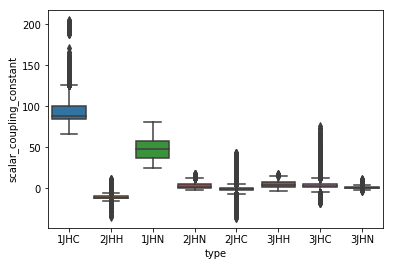

In [45]:
sns.boxplot(x='type',y='scalar_coupling_constant',data=train)

**Очевидно что каждый тип связи дает разное нормальное распределение. Таким образом, тип связи является хорошим предиктором константы связи.**

In [46]:
trainMerged = pd.merge(train, structures, how = 'left',left_on  = ['molecule_name', 'atom_index_0'],
                  right_on = ['molecule_name',  'atom_index'])
trainMerged.rename(columns={'atom': 'atom_0','x': 'x_0','y': 'y_0','z': 'z_0'}, inplace=True)


trainMerged = pd.merge(trainMerged, structures, how = 'left',
                  left_on  = ['molecule_name', 'atom_index_1'],
                  right_on = ['molecule_name',  'atom_index'])
trainMerged.rename(columns={'atom': 'atom_1','x': 'x_1','y': 'y_1','z': 'z_1'}, inplace=True)

trainMerged.drop(['atom_index_x','atom_index_y'], axis=1, inplace=True)

trainMerged.head(3)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.00215,-0.006031,0.001976,C,-0.012698,1.085804,0.008001
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.00215,-0.006031,0.001976,H,1.011731,1.463751,0.000277
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.00215,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644


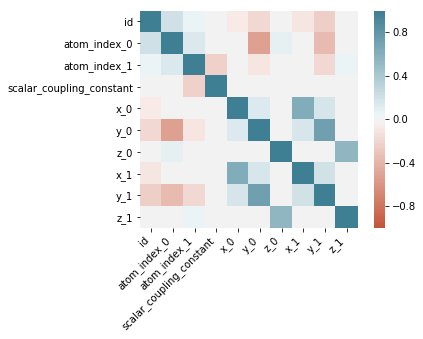

In [47]:

corr = trainMerged.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

**Константа связи не имеет линейной корреляции с положением атомов. Посмотрим,есть ли зависимость между расстоянием (евклидово расстояние).**

In [0]:
def EuclideanDistance(x,y,z):
    return np.power(x**2 + y**2 + z**2,0.5)
    
vecDist = np.vectorize(EuclideanDistance)

In [0]:
trainMerged['RelPos_x'] = np.abs(trainMerged['x_0'] - trainMerged['x_1'])
trainMerged['RelPos_y'] = np.abs(trainMerged['y_0'] - trainMerged['y_1'])
trainMerged['RelPos_z'] = np.abs(trainMerged['z_0'] - trainMerged['z_1'])
trainMerged['Euc_Dist'] = vecDist(trainMerged.RelPos_x, trainMerged.RelPos_y ,trainMerged.RelPos_z)

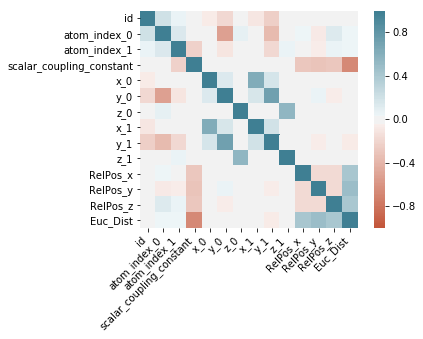

In [50]:

corr = trainMerged.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

**Относительное расположение показывает слабую отрицательную корреляцию.
Евклидово расстояние показывает сильную отрицательную корреляцию.
В целом в данных очень мало линейных зависимостей, поэтому линейная регрессия не кажется подходящим инструментом для моделирования.** 

In [51]:
molecuesDf = structures[['molecule_name','atom']].groupby('molecule_name').count().reset_index()
molecuesDf.columns = ['molecule_name','atomCount']
molecuesDf.head(3)

,molecule_name,atomCount
0,dsgdb9nsd_000001,5
1,dsgdb9nsd_000002,4
2,dsgdb9nsd_000003,3


In [52]:
trainMerged = pd.merge(trainMerged, molecuesDf, how = 'left',
                  left_on  = ['molecule_name'],
                  right_on = ['molecule_name'] )
trainMerged.head(3)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,RelPos_x,RelPos_y,RelPos_z,Euc_Dist,atomCount
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.00215,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,0.014849,1.091835,0.006025,1.091953,5
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.00215,-0.006031,0.001976,H,1.011731,1.463751,0.000277,1.009580,1.469782,0.001700,1.783120,5
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.00215,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644,0.542965,1.453558,0.878620,1.783147,5


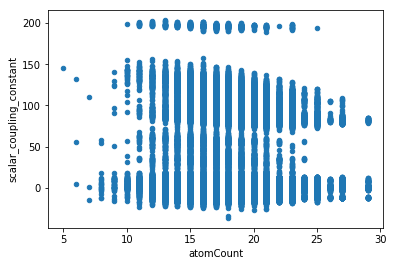

In [53]:
trainMerged.sample(frac=0.05, random_state=2019).plot(x='atomCount', y='scalar_coupling_constant', kind='scatter')

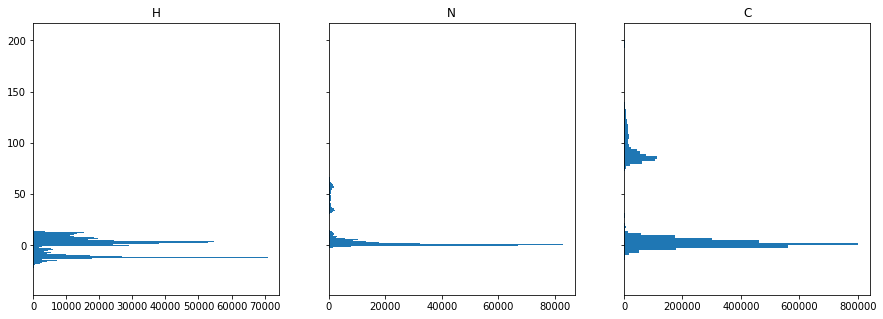

In [54]:
f, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(15,5))

for i,t in enumerate(set(trainMerged.atom_1)):
    ax[i].hist(trainMerged[trainMerged.atom_1==t].scalar_coupling_constant,orientation="horizontal", bins=100) 
    ax[i].set_title(t)

Атомы, участвующие в соединении молекул, также обусловливают распределение коэффициента связи.
Выводы до сих пор:
1.Тип связи, тип атома и евклидово расстояние являются лучшими предикторами и, следовательно, важными характеристиками.
2. Корреляционный анализ показывает, что существует лишь несколько слабых линейных зависимостей и поэтому нелинейное моделирование должно быть предпочтительным.
3. Интуитивно понятно, что пространственные корреляции, близость к другим атомам и состав молекулы должны играть роль в коэффициенте связи. Таким образом, тщательный эксперимент, основанный на features engeeniring, который включает в себя окружающую информацию атомов, участвующих в пространстве признаков, улучшит производительность.

В качестве базовой модели предлагается использоваться RandomForestRegressor. Поскольку это ансамбль деревьев решений и в добавок, в нашем случае мы запускаем его еще по каждому классу в отдельности, можно неплохого скора для такой базовой модели.

In [55]:
train = train.sample(frac=0.1, replace=False, random_state=2019)
train.shape

(465815, 6)

In [56]:
trainMerged = pd.merge(train, structures, how = 'left',left_on  = ['molecule_name', 'atom_index_0'],
                  right_on = ['molecule_name',  'atom_index'])
trainMerged.rename(columns={'atom': 'atom_0','x': 'x_0','y': 'y_0','z': 'z_0'}, inplace=True)


trainMerged = pd.merge(trainMerged, structures, how = 'left',
                  left_on  = ['molecule_name', 'atom_index_1'],
                  right_on = ['molecule_name',  'atom_index'])
trainMerged.rename(columns={'atom': 'atom_1','x': 'x_1','y': 'y_1','z': 'z_1'}, inplace=True)

trainMerged.drop(['atom_index_x','atom_index_y'], axis=1, inplace=True)

trainMerged.head(3)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1
0,1164923,dsgdb9nsd_039011,9,8,2JHC,1.27218,H,-0.583182,1.971750,0.803563,C,-0.017013,0.014571,0.025109
1,4441950,dsgdb9nsd_122989,15,16,3JHH,3.53842,H,-1.706262,-0.254513,-1.102151,H,-0.636574,-2.476063,-0.612832
2,4566146,dsgdb9nsd_127768,13,4,3JHC,7.92151,H,0.120346,-2.510468,3.880919,C,0.017184,-2.120399,0.606965


In [0]:
trainMerged['RelPos_x'] = np.abs(trainMerged['x_0'] - trainMerged['x_1'])
trainMerged['RelPos_y'] = np.abs(trainMerged['y_0'] - trainMerged['y_1'])
trainMerged['RelPos_z'] = np.abs(trainMerged['z_0'] - trainMerged['z_1'])
trainMerged['Euc_Dist'] = vecDist(trainMerged.RelPos_x, trainMerged.RelPos_y ,trainMerged.RelPos_z)

In [0]:

labelencoder = LabelEncoder()
def labelEncodeCategoricalFeatures(DF):
    df = DF.copy()
    for c in df.columns:
        if df[c].dtype.name == 'object':
            df[c] = labelencoder.fit_transform(df[c])
    return df

In [0]:
X = trainMerged[['type','RelPos_x','RelPos_y','RelPos_z','Euc_Dist', 'atom_0','atom_1']]
Y = trainMerged['scalar_coupling_constant']

In [0]:
X = labelEncodeCategoricalFeatures(X).values

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=2019)
print("Train Test Split:")
print(np.array(X_train).shape, np.array(X_test).shape, np.array(y_train).shape, np.array(y_test).shape)

Train Test Split:
(312096, 7) (153719, 7) (312096,) (153719,)


In [0]:
def competetionMetric(types,y_test, yhat):
    maeList = []
    for t in set(types):
        yt = y_test[types==t]
        yh = yhat[types==t]
        maeList.append(mean_absolute_error(yt, yh))
    return np.mean(np.log(maeList))

In [0]:
def evaluateModel(types,y_test, yhat):
    print('Coefficient of determination: ',r2_score(y_test, yhat))
    print('MAE: ',mean_absolute_error(y_test, yhat))
    print('Competition Metric: ',competetionMetric(types,y_test, yhat))

In [0]:
def naiveBaseLine(X_train, X_test, y_train, y_test):
    yhat = np.ones(len(y_test)) * np.mean(y_train)
    types = X_test[:,0]
    evaluateModel(types, y_test, yhat)

In [0]:
def typeAwareBaseLine(X_train, X_test, y_train, y_test):
    yhat = np.zeros(len(y_test))
    trainDf = pd.DataFrame({'type':X_train[:,0], 'y':y_train})
    meansDf = trainDf.groupby('type').mean()
    meanDict = dict(zip(meansDf.index,meansDf.y))
    types = X_test[:,0]
    yhat = np.array([meanDict[t] for t in types])
    evaluateModel(types, y_test, yhat)

In [0]:
def randomForestModel(X_train, X_test, y_train, y_test):
    regr = RandomForestRegressor(max_depth=10, random_state=2019,n_estimators=100)
    regr.fit(X_train,y_train)
    yhat = regr.predict(X_test)
    types = X_test[:,0]
    evaluateModel(types,y_test, yhat)

In [0]:
def typeAwareRandomForestModel(X_train, X_test, y_train, y_test):
    models = {}
    types = X_train[:,0]
    for t in set(types):
        yt = y_train[types==t]
        xt = X_train[types==t]
        regr = RandomForestRegressor(max_depth=10, random_state=2019,n_estimators=100)
        regr.fit(xt,yt)
        models[t] = regr
    
    types = X_test[:,0]
    yhat = np.zeros(X_test.shape[0])
    for t in set(types):
        yhat[types==t] = models[t].predict(X_test[types==t])

    evaluateModel(types,y_test, yhat)

In [68]:
naiveBaseLine(X_train, X_test, y_train, y_test)

Coefficient of determination:  -8.450199473486464e-08
MAE:  24.704489937809655
Competition Metric:  3.0050981356316186


In [69]:
typeAwareBaseLine(X_train, X_test, y_train, y_test)

Coefficient of determination:  0.9491971280828202
MAE:  4.223286898462774
Competition Metric:  1.2370112580467425


In [70]:
randomForestModel(X_train, X_test, y_train, y_test)

Coefficient of determination:  0.9867362214020043
MAE:  2.510367502407664
Competition Metric:  0.7376097382637715


In [71]:
typeAwareRandomForestModel(X_train, X_test, y_train, y_test)

Coefficient of determination:  0.9868910323813865
MAE:  2.463926135216887
Competition Metric:  0.7134374878850425
